# Training and applying a XGBoost model

## Prerequisites:
- you need to have an instance of the geo engine running with active `xgboost` feature
- you need to download an external dataset for this example (see below for more info)
- you need to specify the `admin_session_token` in the `settings-default.toml`
- you need to increase the `tile_limit` in the `settings-default.toml` to a big number (e.g. 10000)
- Set the target directory for the trained xgboost model file
    - this assumes, `geoengine` and `geoengine-python` are located side by side in the filesystem. 
    - change path accordingly if neccessary
    
### NOTE: 
be aware, that this notebook will need some time to run. 

In [1]:
import os

ge_pro_model_path = os.path.join(
    os.getcwd(), "..", "..", "geoengine/test_data/pro/ml/xgboost/s2_10m_de_marburg"
)

In [2]:
import sys
import time
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import xgboost as xgb
from matplotlib.colors import ListedColormap

import geoengine as ge
from geoengine import StoredDataset
from geoengine.colorizer import Colorizer

ge.initialize(
    "http://localhost:3030", admin_token="8aca8875-425a-4ef1-8ee6-cdfc62dd7525"
)
session = ge.get_session()

## Download class label dataset
- Download: [Mundialis Classification Map](https://data.mundialis.de/geodata/lulc-germany/classification_2019/classification_map_germany_2019_v02.tif)
- optional: use the following cell to download the dataset and move it to the correct position in the backend.
- alternatively you'll have to download the dataset manually and put it somewhere under the `test_data` folder of the backend

In [3]:
def progress_bar(current, total, unit: str = "MB"):

    done = int(50 * current / total)

    current_fmt = int(current / (1000000 if unit == "MB" else 1))
    total_fmt = int(total / (1000000 if unit == "MB" else 1))

    sys.stdout.write(
        "\rProgress: [{}{}] ~ {} of {} {}".format(
            "█" * done, "." * (50 - done), current_fmt, total_fmt, unit
        )
    )
    sys.stdout.flush()


def download(
    filename: str = "classification_map_germany_2019_v02.tif",
    url: str = "https://data.mundialis.de/geodata/lulc-germany/classification_2019/classification_map_germany_2019_v02.tif",
    download_location: str = "geoengine/test_data/raster",
):
    """
    This method wraps the download procedure of the example dataset download.
    It will download the dataset and place it under the specified location in your filesystem.

        Parameters:
            url (str): URL to the dataset.
            filename (str): The name of the dataset on your filesystem.
            download_location (str): Where the dataset should be located at on your filesystem.
            The path is constructed relative to your notebooks location.

    """
    import subprocess

    dl = os.path.realpath(
        f"{os.path.join(os.getcwd(), '..', '..', f'{download_location}/{filename}')}"
    )

    # check, if download is even neccessary
    if os.path.exists(dl):
        print("File already exists at specified path!")
        print(f"Path:\n {dl}!")
        return

    with open(dl, "wb") as f:
        response = requests.get(url, stream=True)
        total = response.headers.get("content-length")

        if total is None:
            f.write(response.content)
        else:
            print("Starting download of mundialis example dataset...\n")
            downloaded = 0
            total = int(total)

            for data in response.iter_content(
                chunk_size=max(int(total / 1000), 1024 * 1024)
            ):
                downloaded += len(data)
                f.write(data)

                progress_bar(downloaded, total)

    print("\n\nDownload finished!")
    print("File located at: {}".format(dl))


# start the download
download()

File already exists at specified path!
Path:
 /home/droenner/git/geoengine/test_data/raster/classification_map_germany_2019_v02.tif!


### Add the class labels to the geo engine as a known dataset
- The classification dataset is not part of the geo engine. Therefore we need to specify the details and add the dataset manually.

In [4]:
file_path = "raster/classification_map_germany_2019_v02.tif"  # specify file path relative to volume path

rasterband_channel = 1

geo_transform = ge.api.GdalDatasetGeoTransform(
    {"originCoordinate": [279370.0, 6102450.0], "xPixelSize": 10.0, "yPixelSize": -10.0}
)

width = 64293
height = 86760

file_not_found_handling = ge.api.FileNotFoundHandling.NODATA

gdal_params = ge.api.GdalDatasetParameters(
    {
        "filePath": file_path,
        "rasterbandChannel": rasterband_channel,
        "geoTransform": geo_transform,
        "width": width,
        "height": height,
        "fileNotFoundHandling": file_not_found_handling,
        "noDataValue": None,
        "propertiesMapping": None,
        "gdalOpenOptions": None,
        "gdalConfigOptions": None,
        "allowAlphabandAsMask": True,
    }
)

time_bounds = ge.TimeInterval(start = datetime.strptime("2020-01-01T00:00:00.000Z", "%Y-%m-%dT%H:%M:%S.%f%z"), end = datetime.strptime("2020-12-01T00:00:00.000Z", "%Y-%m-%dT%H:%M:%S.%f%z"))
spatial_bounds = ge.SpatialPartition2D(279370.0, 5234850.0, 922300.0,6102450.0)
spatial_resolution = ge.SpatialResolution(10.0, 10.0)

classified_measurement = ge.ClassificationMeasurement(
    measurement="Landnutzung",
    classes= {
            0: "Forest",
            1: "Low Vegetation",
            2: "Water",
            3: "Buildings",
            4: "Soil",
            5: "Agriculture",
        },
)


result_descriptor = ge.RasterResultDescriptor(data_type="I16", spatial_reference="EPSG:4326", measurement=classified_measurement, spatial_bounds=spatial_bounds, time_bounds=time_bounds, spatial_resolution=spatial_resolution)
result_descriptor_dict = result_descriptor.to_api_dict()


meta_data = ge.api.GdalMetaDataStatic(
    {
        "type": "GdalStatic",
        "time": None,
        "params": gdal_params,
        "resultDescriptor": result_descriptor_dict,
    }
)

add_dataset_properties = ge.AddDataset(dataset_id=None, name="Thing", description="Thing", source_operator="GdalSource")
    

# now we can add the dataset, making it available for further usage within the geo engine
volumes = ge.volumes()
dataset_id = ge.add_public_raster_dataset(
    volumes[0].name, add_dataset_properties, meta_data
)

10.0,10.0 <class 'geoengine.types.SpatialResolution'>


## Define your query parameters here

In [5]:
time = ge.TimeInterval(start = datetime.strptime("2020-06-01T00:00:00.000Z", "%Y-%m-%dT%H:%M:%S.%f%z"))

bbox = ge.BoundingBox2D(474112, 5612032, 522752, 5646336)
resolution = ge.SpatialResolution(10, 10)

## Fetch training data 

In [24]:
def workflow_definition(band: str):
    """This method is used to build a sentinel 2 request with the given specification."""
    return {
        "type": "Raster",
        "operator": {
            "type": "TemporalRasterAggregation",
            "params": {
                "aggregation": {"type": "mean", "ignoreNoData": True},
                "window": {"granularity": "days", "step": 10},
            },
            "sources": {
                "raster": {
                    "type": "GdalSource",
                    "params": {
                        "data": {
                            "type": "external",
                            "providerId": "5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5",
                            "layerId": f"UTM32N:{band}",
                        }
                    },
                },
            },
        },
    }


def generate_sentinel_dataset(
    bbox=bbox, time_start=time, time_end=time, resolution=resolution, srs="EPSG:32632"
):
    """This method is used to query the geo engine with the given specs. It returns a dataframe containing the band data."""

    from IPython.display import clear_output

    band_ids = ["B02", "B03", "B04", "B08"]

    bands = []

    for i, b in enumerate(band_ids):

        band_fmt = "\n".join(
            [
                "\033[1m" + f"{band_id}" + " ...fetching \033[0m"
                if i == j
                else (band_id if j >= i else f"{band_id} ...done")
                for j, band_id in enumerate(band_ids)
            ]
        )

        clear_output()
        progress_bar(i, len(band_ids), unit="Bands")

        workflow = ge.register_workflow(workflow_definition(band=b))

        task = workflow.save_as_dataset(
            ge.api.RasterQueryRectangle({
                "spatialBounds": ge.SpatialPartition2D(bbox.xmin, bbox.ymin, bbox.xmax, bbox.ymax).to_api_dict(),
                "timeInterval": ge.api.TimeInterval({ # FIXME: use time_start and time_end
                    "start": '2020-06-01T00:00:00.000Z',
                    "end": '2020-06-01T00:00:00.000Z'
                }),
                "spatialResolution": resolution.to_api_dict(),
            }),
            f"XGBoost Training Data (Band: {b[1:]})",
            "A dataset used, to train a xgboost model.",
        )

        

        task_status_info = task.wait_for_finish(60, print_status=False)
        bands.append(StoredDataset.from_response(task_status_info.info))
        
        # clear output and print the final state
        if i+1 == len(band_ids):
            clear_output()
            final_output = "".join([f"{x} ...done\n" for x in band_ids])
            print(final_output)
            progress_bar(i+1, len(band_ids), unit="Bands")

    return bands

In [7]:
stored_ds = generate_sentinel_dataset()
stored_ds

B02 ...done
B03 ...done
B04 ...done
B08 ...done

Progress: [██████████████████████████████████████████████████] ~ 4 of 4 Bands

[StoredDataset(dataset_id=5b2b5210-946c-4c33-a09b-208f07acb2b4, upload_id=8da94495-1800-455a-9d4e-edadc19a1f0e),
 StoredDataset(dataset_id=24a57598-6597-4450-bc7a-d0800ca6a264, upload_id=087df575-1214-4b14-abcd-58ba0e22b86f),
 StoredDataset(dataset_id=23a2fb0f-fb51-47ea-86aa-11183acd2682, upload_id=4ebbbb1e-25d6-4219-9038-6ebd5e83868f),
 StoredDataset(dataset_id=83f39e98-2ce3-49f8-a49a-aa09ff42ac81, upload_id=1415614a-26e0-4726-bb30-9f0a5a001b1b)]

## Use the geo engine to query the stored datasets. This will make the data available for further usage.
You can get the data in form of an xarray. This can then be used to shape the data to whatever you want it to be. In this case we convert it to a dataframe, where each band is stored as a column. This format is understood by xgboost and we can train our model with it.

In [9]:
xrays = []

for band in stored_ds:
    print(f"Generating xarray data structure for band with id: {band.dataset_id}")
    data = ge.register_workflow(
        {
            "type": "Raster",
            "operator": {
                "type": "GdalSource",
                "params": {
                    "data": {"type": "internal", "datasetId": str(band.dataset_id)}
                },
            },
        }
    )

    xrays.append(
        data.get_xarray(
            ge.QueryRectangle(
                bbox, time, resolution=resolution, srs="EPSG:32632"
            )
        )
        .to_numpy()
        .flatten()
    )

Generating xarray data structure for band with id: 5b2b5210-946c-4c33-a09b-208f07acb2b4
10.0,10.0 <class 'geoengine.types.SpatialResolution'>
Generating xarray data structure for band with id: 24a57598-6597-4450-bc7a-d0800ca6a264
10.0,10.0 <class 'geoengine.types.SpatialResolution'>
Generating xarray data structure for band with id: 23a2fb0f-fb51-47ea-86aa-11183acd2682
10.0,10.0 <class 'geoengine.types.SpatialResolution'>
Generating xarray data structure for band with id: 83f39e98-2ce3-49f8-a49a-aa09ff42ac81
10.0,10.0 <class 'geoengine.types.SpatialResolution'>


In [10]:
# merge xarrays into a single dataframe
df_bands = pd.DataFrame(
    {"b2": xrays[0], "b3": xrays[1], "b4": xrays[2], "b8": xrays[3]}
)

df_bands

,b2,b3,b4,b8
0,4059,3859,3449,5483
1,4043,3819,3512,5296
2,3981,3770,3518,5081
3,3937,3721,3481,5089
4,3900,3725,3455,5141
...,...,...,...,...
16688379,3630,3697,3671,6036
16688380,3508,3598,3465,6171
16688381,3425,3496,3378,6320
16688382,3290,3387,3323,6215


## Register a workflow to make the label data available with the geo engine

In [11]:
labels_wf = ge.register_workflow(
    {
        "type": "Raster",
        "operator": {
            "type": "GdalSource",
            "params": {
                "data": {"type": "internal", "datasetId": str(dataset_id)},
            },
        },
    }
)

labels_wf.get_result_descriptor()

10.0,10.0 <class 'geoengine.types.SpatialResolution'>


## Use the geo engine to provide the class labels for the query rectangle.

In [14]:
time_labels = ge.TimeInterval(datetime.strptime("2020-01-01T00:00:00.000Z", "%Y-%m-%dT%H:%M:%S.%f%z"))

data = labels_wf.get_xarray(
    ge.QueryRectangle(
        bbox, time_labels, resolution=resolution, srs="EPSG:32632"
    )
)

display(data)

<xarray.DataArray (band: 1, y: 3431, x: 4864)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=int16)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4.741e+05 4.741e+05 ... 5.227e+05 5.227e+05
  * y            (y) float64 5.646e+06 5.646e+06 ... 5.612e+06 5.612e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    crs:           EPSG:32632
    res:           (10.0, -10.0)
    transform:     | 10.00, 0.00, 474112.00|\n| 0.00,-10.00, 5646336.00|\n| 0...

<AxesSubplot: xlabel='labels'>

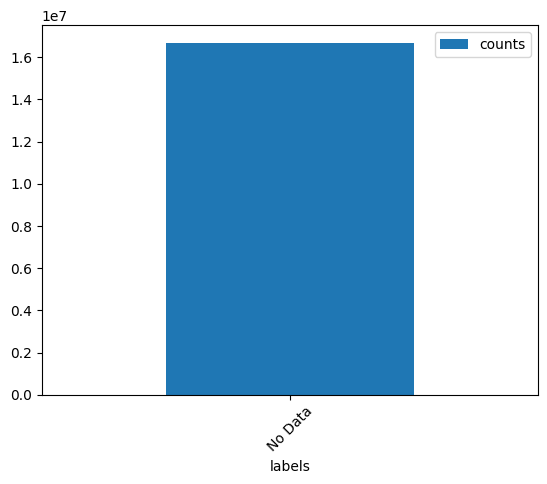

In [15]:
label = pd.DataFrame(data.squeeze().to_numpy().flatten())

(
    pd.DataFrame(
        pd.DataFrame(label.to_numpy().flatten())[0].map(
            {
                0: "No Data",
                10: "Forest",
                20: "Low Vegetation",
                30: "Water",
                40: "Buildings",
                50: "Soil",
                60: "Agriculture",
            }
        )
    )
    .value_counts()
    .rename("counts")
    .to_frame()
    .reset_index()
    .rename(columns={0: "labels"})
    .plot(kind="bar", x="labels", rot=45)
)

In [16]:
# XGBoost wants the labels to be integers starting from zero
label[0] = label[0].map(
    {
        0: 0,
        10: 1,
        20: 2,
        30: 3,
        40: 4,
        50: 5,
        60: 6,
    }
)

# XGBoost

## Set parameters and train a model

In [17]:
dtrain = xgb.DMatrix(df_bands, label=label)
param = {
    "max_depth": 6,
    "eta": 0.5,
    "objective": "multi:softmax",
    "num_class": 7,
    "validate_parameters": 1,
    "tree_method": "hist",
}
evallist = [(dtrain, "train")]
num_round = 2
bst = xgb.train(param, dtrain, num_round, evals=evallist)

[0]	train-mlogloss:0.57598
[1]	train-mlogloss:0.32299


## Store the xgboost model file

In [18]:
bst.save_model(os.path.join(ge_pro_model_path, "mod.json"))

## Define workflow for XGBoost predictions
- set the operator
- set the source bands used to predict from
- define the query parameters

In [19]:
prediction_wf = ge.register_workflow(
    {
        "type": "Raster",
        "operator": {
            "type": "XgboostOperator",
            "params": {
                "modelSubPath": "xgboost/s2_10m_de_marburg/mod.json",
                "noDataValue": -1000.0,
            },
            "sources": {
                "rasters": [
                    {
                        "type": "GdalSource",
                        "params": {
                            "data": {
                                "type": "internal",
                                "datasetId": str(stored_ds[0].dataset_id),
                            }
                        },
                    },
                    {
                        "type": "GdalSource",
                        "params": {
                            "data": {
                                "type": "internal",
                                "datasetId": str(stored_ds[1].dataset_id),
                            }
                        },
                    },
                    {
                        "type": "GdalSource",
                        "params": {
                            "data": {
                                "type": "internal",
                                "datasetId": str(stored_ds[2].dataset_id),
                            }
                        },
                    },
                    {
                        "type": "GdalSource",
                        "params": {
                            "data": {
                                "type": "internal",
                                "datasetId": str(stored_ds[3].dataset_id),
                            }
                        },
                    },
                ]
            },
        },
    }
)

10.0,10.0 <class 'geoengine.types.SpatialResolution'>


## Execute the query
- this will trigger the xgboost prediction operator and fetch the newly created tiles

In [21]:
predictions = prediction_wf.get_xarray(
    ge.QueryRectangle(bbox, time, resolution=resolution, srs="EPSG:32632"),
)

predictions

<xarray.DataArray (band: 1, y: 3431, x: 4864)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4.741e+05 4.741e+05 ... 5.227e+05 5.227e+05
  * y            (y) float64 5.646e+06 5.646e+06 ... 5.612e+06 5.612e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    crs:           EPSG:32632
    res:           (10.0, -10.0)
    transform:     | 10.00, 0.00, 474112.00|\n| 0.00,-10.00, 5646336.00|\n| 0...

## Show distribution of predicted values

<AxesSubplot: xlabel='labels'>

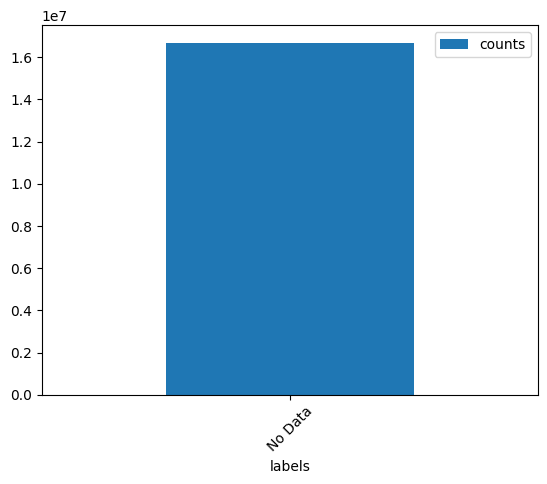

In [22]:
(
    pd.DataFrame(
        pd.DataFrame(predictions.to_numpy().flatten())[0].map(
            {
                0.0: "No Data",
                1.0: "Forest",
                2.0: "Low Vegetation",
                3.0: "Water",
                4.0: "Buildings",
                5.0: "Soil",
                6.0: "Agriculture",
            }
        )
    )
    .value_counts()
    .rename("counts")
    .to_frame()
    .reset_index()
    .rename(columns={0: "labels"})
    .plot(kind="bar", x="labels", rot=45)
)

## Plot the data

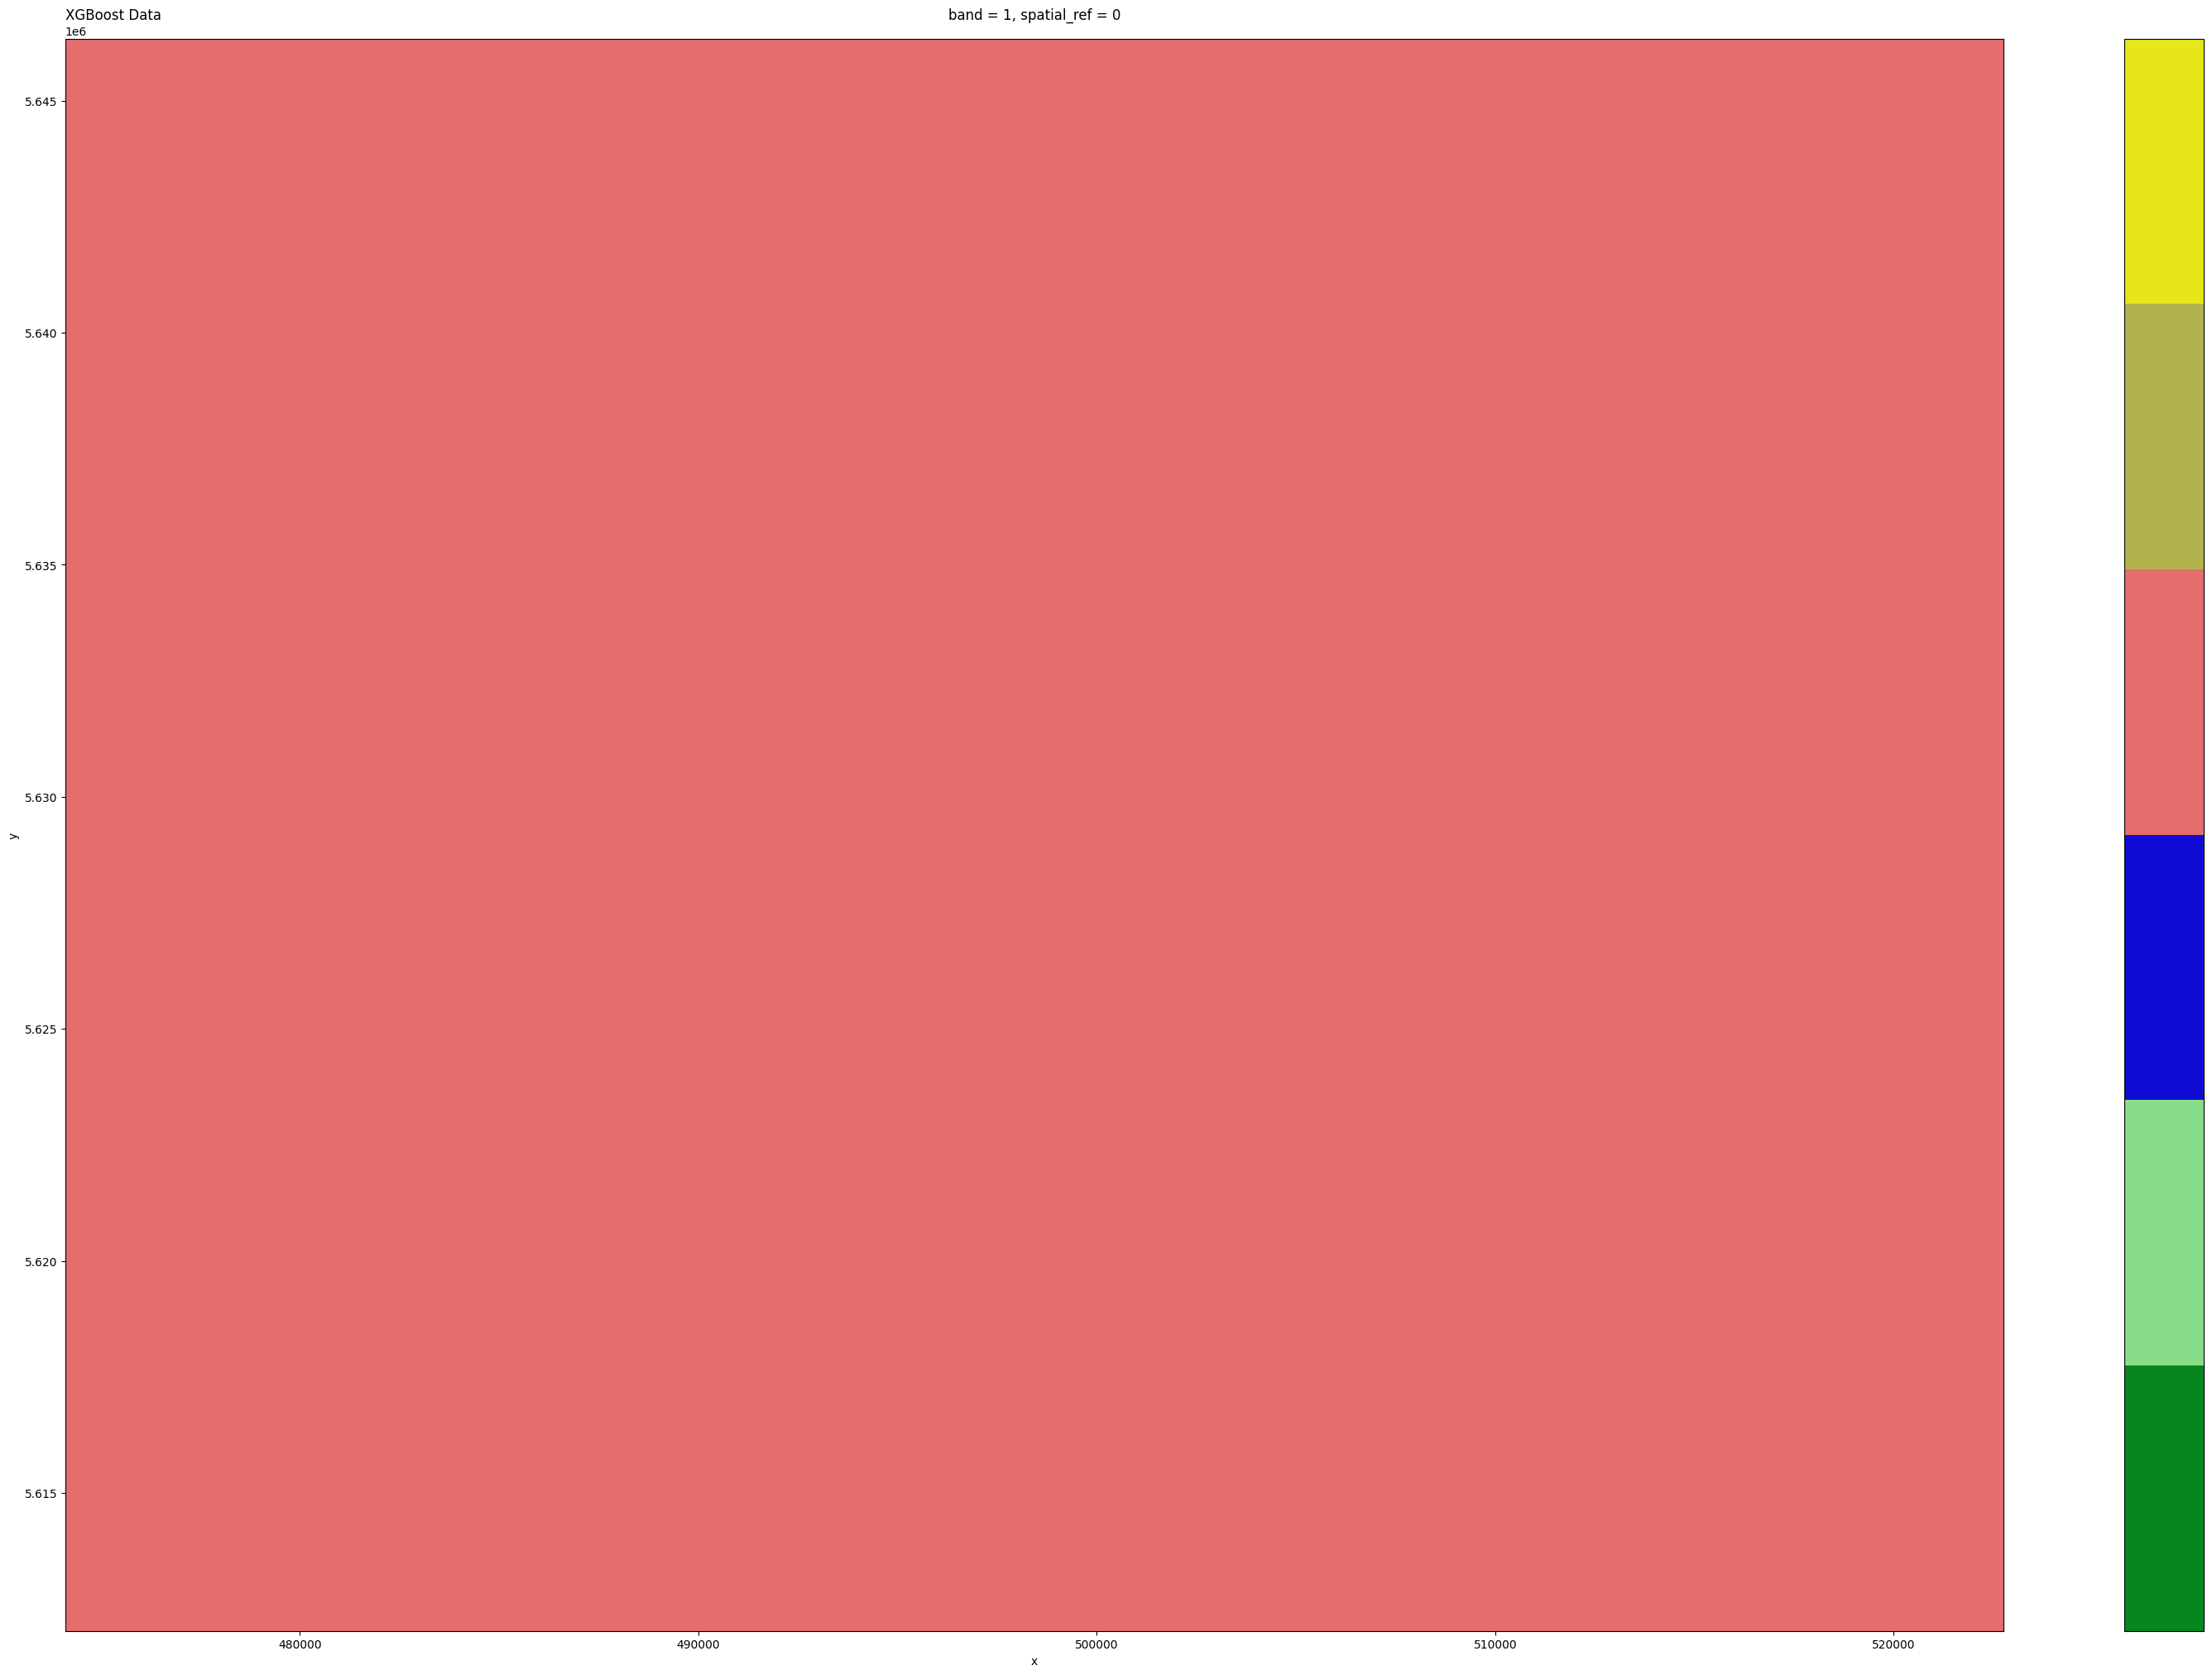

In [23]:
fig, ax = plt.subplots(nrows=1, figsize=(30, 20))
ax.set_title("XGBoost Data", loc="left")

plt.tight_layout()

# we need to remove the colors, that haven't been predicted
cmap = ListedColormap(
    [
        (4 / 256, 135 / 256, 29 / 256, 255 / 256),  # green
        (137 / 256, 222 / 256, 137 / 256, 255 / 256),  # lime
        (14 / 256, 10 / 256, 214 / 256, 255 / 256),  # blue
        (229 / 256, 109 / 256, 109 / 256, 255 / 256),  # pastel red
        (180 / 256, 180 / 256, 77 / 256, 255 / 256),  # dark yellow/greenish
        (231 / 256, 231 / 256, 25 / 256, 255 / 256),  # yellow
        # (0/256, 0/256, 0/256, 0/256), # no data color
    ]
)

cax = predictions.plot(ax=ax, cmap=cmap, add_colorbar=False)

# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax, ticks=[1, 2, 3, 4, 5, 6])
cbar.ax.set_yticklabels(
    ["Forest", "Low Vegetation", "Water", "Buildings", "Soil", "Agriculture"]
)